# Project: Wrangle and Analyze Data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#cleaning">Data Cleaning</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The purpose of this project is to prepare and analyze the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. WeRateDogs has over 4 million followers and has received international media coverage.

<a id='wrangling'></a>
## Data Wrangling

In this section of the report, the data will be loaded and inspected. By the end of it it will be clear all data that must be trimmed, cleaned and modified in order to enhance the analysis.

### General Properties
#### Import packages

In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy as tp
import json
import os
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style ('darkgrid')
sns.set(style="ticks", color_codes=True)


%matplotlib inline

#### Load data

In [2]:
#manual download of the twitter archives

In [3]:
df_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [4]:
#programmatic download of tweet image predictions

In [5]:
response = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
with open('image-predictions.tsv', mode='wb') as file:
    file.write(response.content)

In [6]:
df_images = pd.read_csv('image-predictions.tsv', sep='\t')
df_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [7]:
#create an API object and use to gather Twitter data

In [8]:
consumer_key = 'GBVJLgUBNsNNBhVIHTvbPYGPl'
consumer_secret = '2vkbuta56vPFpvVkVbsxHkAlWDpinCNT6GqiD75A4AhZDQhUXw'
access_token = '1276468223454646272-rT7lT764vTN8qK7m9unfMirlkcStNm'
access_secret = 'q6jqU9UKUPKuNtieNL1UbCw1CvxUK1aEjOFO7IlQOBkNZ'

auth = tp.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tp.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

In [9]:
#Store each tweet's entire set of JSON data in a file called tweet_json.txt

In [10]:
start_loop = time.time()

errors_list = []
tw_list = []

for id in df_archive['tweet_id']:
    try:
        tweets = api.get_status(id, tweet_mode='extended')
        tw_list.append({'tweet_id': int(tweets.id),
                        'retweets': int(tweets.retweet_count),
                        'favorites': int(tweets.favorite_count),
                        'followers_count': int(tweets.user.followers_count)})
    except Exception as ex:
        errors_list.append(id)        

end_loop = time.time()

Rate limit reached. Sleeping for: 735
Rate limit reached. Sleeping for: 739


In [11]:
len(errors_list)

25

In [12]:
time_on_loop = (end_loop - start_loop)/60
time_on_loop

31.816173815727232

In [13]:
#Appending tweets list to json file

In [14]:
with open('tweet_json.txt', 'w', encoding='utf8') as readfile:
    json.dump(tw_list, readfile)

In [15]:
#Create a pandas DataFrame

In [16]:
with open ('tweet_json.txt', 'r', encoding='utf8') as file:
        tw_api = pd.DataFrame(json.load(file), columns=['tweet_id', 'retweets', 'favorites', 'followers_count'])

In [17]:
tw_api.head()

,tweet_id,retweets,favorites,followers_count
0,892420643555336193,7668,36028,8781776
1,892177421306343426,5671,31079,8781776
2,891815181378084864,3759,23390,8781776
3,891689557279858688,7840,39313,8781776
4,891327558926688256,8442,37539,8781776


#### Inspect data

In this section we will assess visually and programmatically the tideness and quality of each data frame (df_archive, df_images, tw_api).

 - We will see the duplicated columns among the three data frames with.()duplicated.
 - We will look at the first few rows with .head( ) to have an idea of how each DataFrame looks like.
 - We will use .info()to see a concise summary of a DataFrame.
 - We will look for NaN data (.isna().sum().any()).
 - We will check if all tweet_ids are unique, or there if there are duplicate.

In [18]:
#check columns that are the same in the three DataFrames

In [19]:
all_columns = pd.Series(list(df_archive) + list(df_images) + list(tw_api))
all_columns[all_columns.duplicated()]

17    tweet_id
29    tweet_id
dtype: object

In [20]:
##### `df_archive` table

In [21]:
df_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [22]:
#check data types, columns and possible missing information

In [23]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [24]:
df_archive.isna().sum().any()

True

In [25]:
df_archive.tweet_id.nunique()

2356

In [26]:
#check numerator and denominator values

In [27]:
df_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [28]:
df_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [29]:
#check if all tweets have images

In [30]:
df_archive['expanded_urls'].isnull().value_counts()

False    2297
True       59
Name: expanded_urls, dtype: int64

In [31]:
#check data types, columns and possible missing information

In [32]:
df_images

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [33]:
df_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [34]:
df_images.isna().sum().any()

False

In [35]:
df_images.tweet_id.nunique()

2075

In [36]:
#check if there are duplicate URLs (dog's pictures)

In [37]:
sum(df_images.jpg_url.duplicated())

66

In [38]:
#check if all pictures are dogs

In [39]:
df_images['p1_dog'].value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [40]:
not_dog_p1 = (df_images.p1_dog == False).sum()

In [41]:
df_images['p2_dog'].value_counts()

True     1553
False     522
Name: p2_dog, dtype: int64

In [42]:
not_dog_p2 = (df_images.p2_dog == False).sum()

In [43]:
df_images['p3_dog'].value_counts()

True     1499
False     576
Name: p3_dog, dtype: int64

In [44]:
not_dog_p3 = (df_images.p3_dog == False).sum()

In [45]:
not_a_dog = not_dog_p1 + not_dog_p2 + not_dog_p3
not_a_dog

1641

In [46]:
#check the predicions of breeds

In [47]:
df_images.p1.value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
malamute                      30
cocker_spaniel                30
French_bulldog                26
Chesapeake_Bay_retriever      23
miniature_pinscher            23
seat_belt                     22
German_shepherd               20
Siberian_husky                20
Staffordshire_bullterrier     20
Cardigan                      19
web_site                      19
teddy                         18
beagle                        18
Maltese_dog                   18
Eskimo_dog                    18
Shetland_sheepdog             18
Shih-Tzu                      17
Rottweiler                    17
Lakeland_terrier              17
Italian_greyhound             16
kuvasz                        16
          

In [48]:
df_images.p2.value_counts()

Labrador_retriever                104
golden_retriever                   92
Cardigan                           73
Chihuahua                          44
Pomeranian                         42
Chesapeake_Bay_retriever           41
French_bulldog                     41
toy_poodle                         37
cocker_spaniel                     34
miniature_poodle                   33
Siberian_husky                     33
beagle                             28
collie                             27
Pembroke                           27
Eskimo_dog                         27
kuvasz                             26
Italian_greyhound                  22
Pekinese                           21
American_Staffordshire_terrier     21
malinois                           20
Samoyed                            20
chow                               20
toy_terrier                        20
miniature_pinscher                 20
Boston_bull                        19
Norwegian_elkhound                 19
Staffordshir

In [49]:
df_images.p3.value_counts()

Labrador_retriever                79
Chihuahua                         58
golden_retriever                  48
Eskimo_dog                        38
kelpie                            35
kuvasz                            34
chow                              32
Staffordshire_bullterrier         32
beagle                            31
cocker_spaniel                    31
Pekinese                          29
toy_poodle                        29
Pomeranian                        29
Great_Pyrenees                    27
Chesapeake_Bay_retriever          27
Pembroke                          27
malamute                          26
French_bulldog                    26
American_Staffordshire_terrier    24
pug                               23
Cardigan                          23
basenji                           21
bull_mastiff                      20
toy_terrier                       20
Siberian_husky                    19
Shetland_sheepdog                 17
Boston_bull                       17
b

In [50]:
#check data types, columns and possible missing information

In [51]:
tw_api

,tweet_id,retweets,favorites,followers_count
0,892420643555336193,7668,36028,8781776
1,892177421306343426,5671,31079,8781776
2,891815181378084864,3759,23390,8781776
3,891689557279858688,7840,39313,8781776
4,891327558926688256,8442,37539,8781776
5,891087950875897856,2831,18919,8781776
6,890971913173991426,1842,10991,8781776
7,890729181411237888,17121,60705,8781776
8,890609185150312448,3895,26030,8781776
9,890240255349198849,6656,29743,8781776


In [52]:
tw_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 4 columns):
tweet_id           2331 non-null int64
retweets           2331 non-null int64
favorites          2331 non-null int64
followers_count    2331 non-null int64
dtypes: int64(4)
memory usage: 72.9 KB


In [53]:
tw_api.isna().sum().any()

False

In [54]:
tw_api.tweet_id.nunique()

2331

#### Quality

##### `df_archive` table
- Timestamp should probably be in dateTime.
- Tweet_id should be a string not an interger.
- There are invalid ratings in the numerators (values from 0 - 1776).
- In the denominator, it seems that the rating should go up to 10 or at least a fixed value but that is not the case.
- There are null values in dog "stage" columns that are not showing as 'None' instead of just being nulls.
- There seems to be some weird dog names such as 'an', 'the', 'a', 'by', etc. Also, there are 745 entries without a name and some as 'None'.
- There are 181 rows that are retweets. We do not want retweets, only original ratings.
 

##### `df_images` table
- Tweet Id should be a string not an interger.
- There is no consistency between the breed names in p1, p2 and p3, some are in lowercase some are not.
- There are some tweets that do not have dog pictures, is from other animals.
- There are 66 duplicated dog images.


#### Tidness

##### `df_archive` table
- It would be better to merge the DataFrames.
- The stage of dog (doggo, floofer, pupper and puppo) are values separated in columns, when in fact should be all in one column.
- There are some rows and columns we are not interested in, so they should be dropped('retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','in_reply_to_status_id','in_reply_to_user_id').



<a id='cleaning'></a>
## Data Cleaning

In this section of the report, we will execute all the trimming, cleaning and modifying necessary to prepare the data to be analyzed.

In [55]:
#create copies of the original data frames

In [56]:
archive_clean = df_archive.copy()
images_clean = df_images.copy()
tw_clean = tw_api.copy()

#### Improve and fix Tidiness issues

In [57]:
#join the Dataframes

In [58]:
#merge archive_clean and tw_clean
df_archive_tw = pd.merge(archive_clean, tw_clean, left_on = 'tweet_id', right_on = 'tweet_id', how='inner')

#merge image_clean to df_archive_tw
df_all = pd.merge(df_archive_tw, images_clean, left_on = 'tweet_id', right_on = 'tweet_id', how = 'inner')

In [59]:
#check with the merge was successful

In [60]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2058
Data columns (total 31 columns):
tweet_id                      2059 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2059 non-null object
source                        2059 non-null object
text                          2059 non-null object
retweeted_status_id           72 non-null float64
retweeted_status_user_id      72 non-null float64
retweeted_status_timestamp    72 non-null object
expanded_urls                 2059 non-null object
rating_numerator              2059 non-null int64
rating_denominator            2059 non-null int64
name                          2059 non-null object
doggo                         2059 non-null object
floofer                       2059 non-null object
pupper                        2059 non-null object
puppo                         2059 non-null object
retweets                      2059 

In [61]:
#Create a column for dog stages and drop the separate

In [62]:
df_all.doggo.replace('None','', inplace = True)
df_all.floofer.replace('None','', inplace = True)
df_all.pupper.replace('None','', inplace = True)
df_all.puppo.replace('None','', inplace = True)

In [63]:
df_all['dog_stage'] = df_all.doggo + df_all.floofer + df_all.pupper + df_all.puppo
df_all.drop(['doggo','floofer','pupper','puppo'], axis=1, inplace=True)

In [64]:
df_all.dog_stage.value_counts()

                1741
pupper           210
doggo             65
puppo             23
doggopupper       11
floofer            7
doggopuppo         1
doggofloofer       1
Name: dog_stage, dtype: int64

In [65]:
#'doggopupper', 'doggopuppo', 'doggofloofer' are not valid stages. This is probably a typing error,  we will consider them as 'doggo'. Since doggo is the beginning of each stage name. 

In [66]:
df_all.loc[df_all.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo'
df_all.loc[df_all.dog_stage == 'doggopuppo', 'dog_stage']= 'doggo'
df_all.loc[df_all.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo'
df_all.dog_stage.value_counts()

           1741
pupper      210
doggo        78
puppo        23
floofer       7
Name: dog_stage, dtype: int64

In [67]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2058
Data columns (total 28 columns):
tweet_id                      2059 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2059 non-null object
source                        2059 non-null object
text                          2059 non-null object
retweeted_status_id           72 non-null float64
retweeted_status_user_id      72 non-null float64
retweeted_status_timestamp    72 non-null object
expanded_urls                 2059 non-null object
rating_numerator              2059 non-null int64
rating_denominator            2059 non-null int64
name                          2059 non-null object
retweets                      2059 non-null int64
favorites                     2059 non-null int64
followers_count               2059 non-null int64
jpg_url                       2059 non-null object
img_num                       2059 non

In [68]:
#set datatype for dog_stage to categorical (Quality issue)

In [69]:
df_all['dog_stage'] = df_all['dog_stage'].astype('category')

In [70]:
#test all changes to dog_stage

In [71]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2058
Data columns (total 28 columns):
tweet_id                      2059 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2059 non-null object
source                        2059 non-null object
text                          2059 non-null object
retweeted_status_id           72 non-null float64
retweeted_status_user_id      72 non-null float64
retweeted_status_timestamp    72 non-null object
expanded_urls                 2059 non-null object
rating_numerator              2059 non-null int64
rating_denominator            2059 non-null int64
name                          2059 non-null object
retweets                      2059 non-null int64
favorites                     2059 non-null int64
followers_count               2059 non-null int64
jpg_url                       2059 non-null object
img_num                       2059 non

In [72]:
#drop retweet rows and columns('retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','in_reply_to_status_id','in_reply_to_user_id'

In [73]:
df_all.drop(df_all[df_all.retweeted_status_id.isnull() == False].index, inplace = True)

In [74]:
#test - see if the number of retweets decreased to 0

In [75]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2058
Data columns (total 28 columns):
tweet_id                      1987 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1987 non-null object
source                        1987 non-null object
text                          1987 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1987 non-null object
rating_numerator              1987 non-null int64
rating_denominator            1987 non-null int64
name                          1987 non-null object
retweets                      1987 non-null int64
favorites                     1987 non-null int64
followers_count               1987 non-null int64
jpg_url                       1987 non-null object
img_num                       1987 non-nu

In [76]:
#drop the columns for retweets and replies

In [77]:
df_all.drop(['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','in_reply_to_status_id','in_reply_to_user_id'], axis=1, inplace=True)

In [78]:
#test

In [79]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2058
Data columns (total 23 columns):
tweet_id              1987 non-null int64
timestamp             1987 non-null object
source                1987 non-null object
text                  1987 non-null object
expanded_urls         1987 non-null object
rating_numerator      1987 non-null int64
rating_denominator    1987 non-null int64
name                  1987 non-null object
retweets              1987 non-null int64
favorites             1987 non-null int64
followers_count       1987 non-null int64
jpg_url               1987 non-null object
img_num               1987 non-null int64
p1                    1987 non-null object
p1_conf               1987 non-null float64
p1_dog                1987 non-null bool
p2                    1987 non-null object
p2_conf               1987 non-null float64
p2_dog                1987 non-null bool
p3                    1987 non-null object
p3_conf               1987 non-null float6

#### Fix datatype issues (Quality)

In [80]:
#fix dog's names with entries: 'None', 'a', 'an', 'the' to NaN (review)

In [81]:
names = list(df_all.name)
non_names = []

for element in names:
    x = re.match('([a-z]+)', element)
    if x:
        non_names.append(x.groups())

In [82]:
print(non_names)

[('such',), ('a',), ('quite',), ('quite',), ('one',), ('incredibly',), ('a',), ('a',), ('very',), ('my',), ('one',), ('not',), ('his',), ('one',), ('a',), ('a',), ('a',), ('an',), ('very',), ('a',), ('just',), ('getting',), ('very',), ('this',), ('unacceptable',), ('all',), ('a',), ('a',), ('infuriating',), ('a',), ('a',), ('a',), ('an',), ('a',), ('a',), ('very',), ('getting',), ('just',), ('a',), ('the',), ('the',), ('actually',), ('by',), ('a',), ('officially',), ('a',), ('the',), ('the',), ('a',), ('a',), ('a',), ('a',), ('a',), ('one',), ('a',), ('a',), ('a',), ('light',), ('just',), ('space',), ('a',), ('the',), ('a',), ('a',), ('a',), ('a',), ('a',), ('a',), ('a',), ('a',), ('a',), ('an',), ('a',), ('a',), ('a',), ('a',), ('a',), ('a',), ('a',), ('a',), ('a',), ('a',), ('a',), ('a',), ('quite',), ('a',), ('an',), ('a',), ('an',), ('the',), ('the',), ('a',), ('a',), ('an',), ('a',), ('a',), ('a',), ('a',)]


In [83]:
non_names = ['a', 'actually', 'an', 'all', 'by', 'getting', 'his', 'incredibly', 'infuriating', 'just', 'light', 'mad', 'my', 'None', 'not', 'one', 'quite', 'space', 'such', 'the', 'this', 'unacceptable', 'very']
for i in non_names:
    df_all.loc[df_all.name == i, 'name'] = None

In [84]:
#test

In [85]:
df_all['name'].value_counts

<bound method IndexOpsMixin.value_counts of 0        Phineas
1          Tilly
2         Archie
3          Darla
4       Franklin
5           None
6            Jax
7           None
8           Zoey
9         Cassie
10          Koda
11         Bruno
12          None
13           Ted
14        Stuart
15        Oliver
16           Jim
17          Zeke
18       Ralphus
19        Gerald
20       Jeffrey
21          None
22        Canela
23          None
24          None
25          Maya
26        Mingus
27         Derek
28        Roscoe
29       Waffles
          ...   
2029        None
2030        None
2031        None
2032        None
2033        None
2034        None
2035        None
2036        None
2037        None
2038        None
2039        None
2040        None
2041        None
2042        None
2043        None
2044        None
2045        None
2046        None
2047        None
2048        None
2049        None
2050        None
2051        None
2052        None
2053        None
2054

In [86]:
#replace 'None' as names, to NaN

In [87]:
df_all['name'] = df_all['name'].replace('None', np.nan)

In [88]:
#test

In [89]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2058
Data columns (total 23 columns):
tweet_id              1987 non-null int64
timestamp             1987 non-null object
source                1987 non-null object
text                  1987 non-null object
expanded_urls         1987 non-null object
rating_numerator      1987 non-null int64
rating_denominator    1987 non-null int64
name                  1344 non-null object
retweets              1987 non-null int64
favorites             1987 non-null int64
followers_count       1987 non-null int64
jpg_url               1987 non-null object
img_num               1987 non-null int64
p1                    1987 non-null object
p1_conf               1987 non-null float64
p1_dog                1987 non-null bool
p2                    1987 non-null object
p2_conf               1987 non-null float64
p2_dog                1987 non-null bool
p3                    1987 non-null object
p3_conf               1987 non-null float6

In [90]:
#fix consistency issue in dog's breeds (review)

In [91]:
# remove the underscore and set all to names in lowercase
df_all['p1'] = df_all['p1'].str.capitalize()
df_all['p2'] = df_all['p2'].str.capitalize()
df_all['p3'] = df_all['p3'].str.capitalize()

In [92]:
#set Null values 
df_all.p1.replace('None','', inplace = True)
df_all.p2.replace('None','', inplace = True)
df_all.p3.replace('None','', inplace = True)

In [93]:
df_all['p1'].value_counts()

Golden_retriever             139
Labrador_retriever            93
Pembroke                      88
Chihuahua                     79
Pug                           54
Chow                          41
Samoyed                       39
Pomeranian                    38
Toy_poodle                    37
Malamute                      29
Cocker_spaniel                27
French_bulldog                25
Chesapeake_bay_retriever      23
Miniature_pinscher            22
Seat_belt                     21
German_shepherd               20
Siberian_husky                20
Teddy                         18
Shetland_sheepdog             18
Staffordshire_bullterrier     18
Maltese_dog                   18
Eskimo_dog                    18
Rottweiler                    17
Cardigan                      17
Beagle                        17
Shih-tzu                      17
Kuvasz                        16
Italian_greyhound             16
Lakeland_terrier              16
Web_site                      15
          

In [94]:
df_all['p2'].value_counts()

Labrador_retriever                96
Golden_retriever                  81
Cardigan                          73
Chihuahua                         43
Chesapeake_bay_retriever          40
French_bulldog                    39
Pomeranian                        39
Toy_poodle                        36
Siberian_husky                    33
Cocker_spaniel                    32
Miniature_poodle                  32
Beagle                            28
Eskimo_dog                        27
Collie                            26
Pembroke                          25
Kuvasz                            24
Italian_greyhound                 22
Pekinese                          21
Malinois                          20
Miniature_pinscher                20
Chow                              20
Toy_terrier                       19
Samoyed                           19
Norwegian_elkhound                19
American_staffordshire_terrier    19
Boston_bull                       18
Staffordshire_bullterrier         17
P

In [95]:
#remove duplicated images by choosing all except them

In [96]:
non_duplicated_images = df_all.jpg_url.duplicated()

In [97]:
non_duplicated_images = np.logical_not(non_duplicated_images)
df_all = df_all[non_duplicated_images]

In [98]:
#remove images that are not animals

In [99]:
df_all.drop(df_all[df_all['p1_dog'] == False].index, inplace=True)

In [100]:
df_all.drop(df_all[df_all['p2_dog'] == False].index, inplace=True)

In [101]:
df_all.drop(df_all[df_all['p3_dog'] == False].index, inplace=True)

In [102]:
#test

In [103]:
not_dog_p1 = (df_all.p1_dog == False).sum()
not_dog_p1

0

In [104]:
not_dog_p2 = (df_all.p2_dog == False).sum()
not_dog_p2

0

In [105]:
not_dog_p3 = (df_all.p3_dog == False).sum()
not_dog_p3 

0

In [106]:
df_all['p3'].value_counts()

Labrador_retriever                62
Chihuahua                         48
Golden_retriever                  33
Eskimo_dog                        31
Kelpie                            28
Staffordshire_bullterrier         27
Pekinese                          26
Kuvasz                            25
Cocker_spaniel                    24
Great_pyrenees                    23
Beagle                            23
Chow                              22
French_bulldog                    21
Toy_poodle                        21
American_staffordshire_terrier    20
Malamute                          20
Pomeranian                        20
Chesapeake_bay_retriever          19
Basenji                           17
Bull_mastiff                      17
Pembroke                          16
Cardigan                          16
Toy_terrier                       16
Boston_bull                       15
Saluki                            14
Lakeland_terrier                  14
Boxer                             14
S

In [107]:
#test

In [108]:
sum(df_all.jpg_url.duplicated())

0

In [109]:
#timestamp to dateTime

In [110]:
#convert
df_all['timestamp'] =pd.to_datetime(df_all['timestamp'])

In [111]:
#test to see if it worked

In [112]:
df_all.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweets,favorites,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,5671,31079,...,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True,
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,3759,23390,...,Chihuahua,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True,
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,8442,37539,...,Basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,
7,890729181411237888,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,None,17121,60705,...,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True,
8,890609185150312448,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,3895,26030,...,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_bay_retriever,0.118184,True,


In [113]:
#fix tweet_id datatype

In [114]:
#convert int to string at the archive_clean DataFrame
df_all['tweet_id'] = df_all['tweet_id'].astype('str')

#convert int to string at the image_clean DataFrame
df_all['tweet_id'] = df_all['tweet_id'].astype('str')

In [115]:
#test to see if it changed

In [116]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1196 entries, 1 to 2058
Data columns (total 23 columns):
tweet_id              1196 non-null object
timestamp             1196 non-null datetime64[ns]
source                1196 non-null object
text                  1196 non-null object
expanded_urls         1196 non-null object
rating_numerator      1196 non-null int64
rating_denominator    1196 non-null int64
name                  846 non-null object
retweets              1196 non-null int64
favorites             1196 non-null int64
followers_count       1196 non-null int64
jpg_url               1196 non-null object
img_num               1196 non-null int64
p1                    1196 non-null object
p1_conf               1196 non-null float64
p1_dog                1196 non-null bool
p2                    1196 non-null object
p2_conf               1196 non-null float64
p2_dog                1196 non-null bool
p3                    1196 non-null object
p3_conf               1196 non-nul

In [117]:
#remove ratings that have high numerators and denominators, as the will hurt the analisys (review)

In [118]:
df_all = df_all.drop(df_all[((df_all['rating_denominator'] != 10) | (df_all['rating_numerator'] >20))].index)

In [119]:
#test

In [120]:
df_all['rating_denominator'].value_counts()

10    1180
Name: rating_denominator, dtype: int64

In [121]:
df_all['rating_numerator'].value_counts()

12    306
10    254
11    244
13    177
9      93
8      50
14     18
7      15
5       9
6       8
4       4
3       1
2       1
Name: rating_numerator, dtype: int64

<a id='eda'></a>
## Exploratory Data Analysis

Now that our data is ready to move on to exploration. In this section we will look to find the relationship between breed, ratings, retweets and favorites and also dog stage, ratings, retweets and favorites. 

<ul>
 <li><a href="#OVER">Variables Overview</a></li>   
<li><a href="#FAVORITES">Tweets and Favorites</a></li>
<li><a href="#RETWEETS">Retweets</a></li>
<li><a href="#RATINGS">Ratings</a></li>
</ul>


In [122]:
#create a new DF with only the columns I will use in the analysis. This automatically create a copy of these columns from df_all.

In [123]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1180 entries, 1 to 2058
Data columns (total 23 columns):
tweet_id              1180 non-null object
timestamp             1180 non-null datetime64[ns]
source                1180 non-null object
text                  1180 non-null object
expanded_urls         1180 non-null object
rating_numerator      1180 non-null int64
rating_denominator    1180 non-null int64
name                  843 non-null object
retweets              1180 non-null int64
favorites             1180 non-null int64
followers_count       1180 non-null int64
jpg_url               1180 non-null object
img_num               1180 non-null int64
p1                    1180 non-null object
p1_conf               1180 non-null float64
p1_dog                1180 non-null bool
p2                    1180 non-null object
p2_conf               1180 non-null float64
p2_dog                1180 non-null bool
p3                    1180 non-null object
p3_conf               1180 non-nul

In [124]:
df_analysis = df_all[['timestamp','tweet_id', 'name', 'p1', 'dog_stage', 'rating_numerator', 'retweets', 'favorites',  'jpg_url']].copy()

<a id='OVER'></a>
## Variables Overview

We will draw a correlation matrix in order to see overall the associations between the variables we are analyzing.

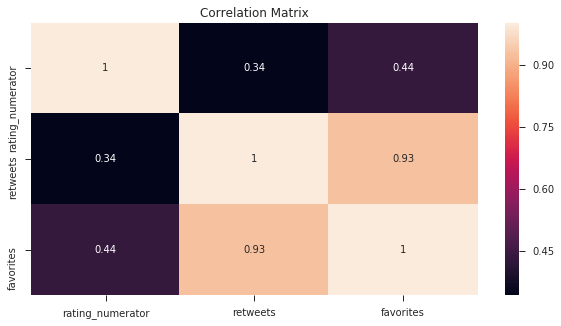

In [125]:
plt.figure(figsize=(10, 5))
df_analysis_corrMatrix = df_analysis.corr()
sns.heatmap(df_analysis_corrMatrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

A value close to 1 indicates stronger positive/regular correlation, closer to a linear function. A value close to -1 indicates stronger negative/inverse correlation, closer to a linear function. A value closer to 0 indicates weaker correlation.

Here, out of all the variables only Retweets and Favorites seem to have weak or no correlation.

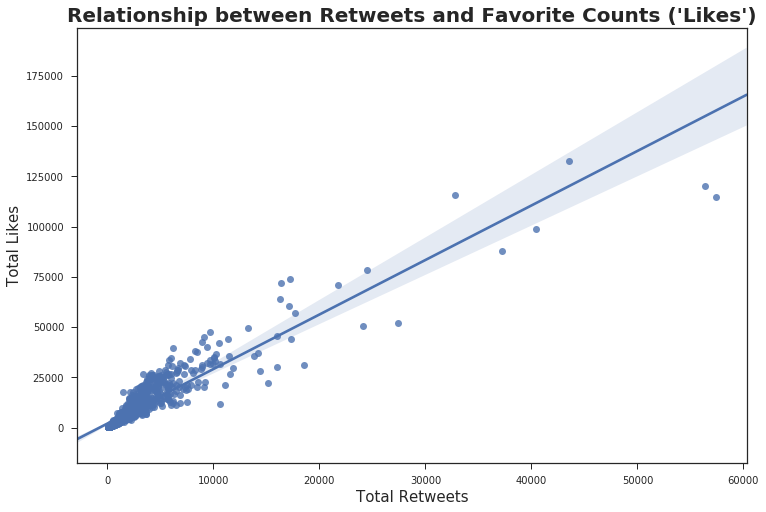

In [126]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.regplot(x='retweets', y='favorites', data=df_analysis, ax = ax)
plt.title("Relationship between Retweets and Favorite Counts ('Likes')", fontsize = 20, weight = 'bold') 
plt.xlabel("Total Retweets", fontsize = 15)
plt.ylabel("Total Likes", fontsize = 15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);

This graph reinforces that there is a positive correlation between retweets and favorites. Which makes sense, since the more favorites a post receives more likely it is that people will repost it or the more times it is retweets the more likes the post will receive.

In [127]:
retweets_df = df_analysis[['timestamp', 'retweets']].groupby(['timestamp']).sum()
retweets_df['retweets'] = retweets_df['retweets'].rolling(window=30).mean()

favorites_df = df_analysis[['timestamp', 'favorites']].groupby(['timestamp']).sum()
favorites_df['favorites'] = favorites_df['favorites'].rolling(window=30).mean()

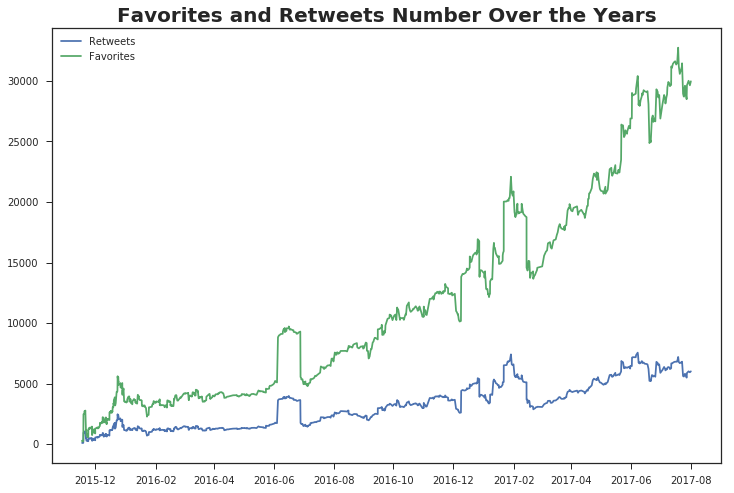

In [128]:
fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(12,8))
axs.set_title('Favorites and Retweets Number Over the Years',fontsize=20, weight = 'bold')
axs.plot(retweets_df, label='Retweets')
axs.plot(favorites_df, label='Favorites')
axs.legend();

However, the graph above shows that over the years the number of favorites grows at a higher rate than the number of the retweets. 

**What are the most commom dog stages?**

In [129]:
dog_stages = df_analysis.dog_stage.value_counts().sort_values(ascending=False)
dog_stages

           992
pupper     118
doggo       46
puppo       18
floofer      6
Name: dog_stage, dtype: int64

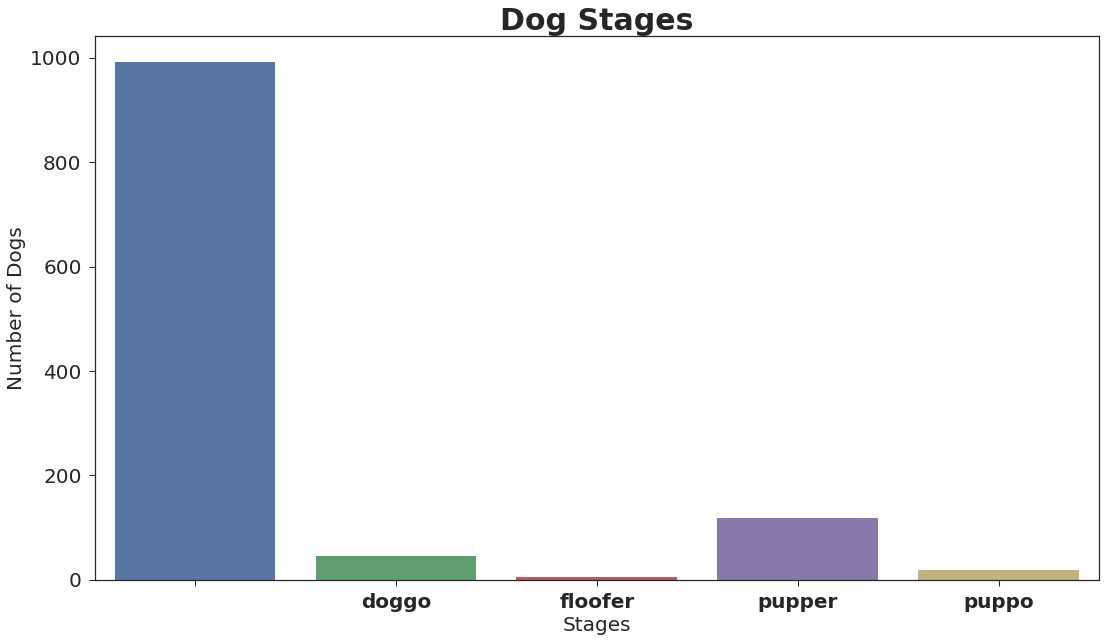

In [130]:
fig, ax = plt.subplots(figsize=(18,10))
labels = np.array(df_analysis.dog_stage)
values = np.array(dog_stages)
g = sns.barplot(x=dog_stages.index, y=dog_stages)
g.set_xticklabels(g.get_xticklabels())
ax = plt.gca()
plt.title('Dog Stages', fontsize = 30, loc = 'center', weight = 'bold')
plt.xlabel('Stages', fontsize = 20)
plt.ylabel('Number of Dogs', fontsize = 20)
plt.xticks(fontsize=20, weight = 'bold')
plt.yticks(fontsize=20);

**What are the 10 most commom predicted breeds?**

In [131]:
main_dog_breeds = df_analysis.p1.value_counts().sort_values(ascending=False)
main_dog_breeds = main_dog_breeds.head(10)
main_dog_breeds

Golden_retriever      115
Pembroke               77
Labrador_retriever     70
Chihuahua              50
Pug                    39
Pomeranian             28
Malamute               26
Chow                   26
Toy_poodle             25
Samoyed                24
Name: p1, dtype: int64

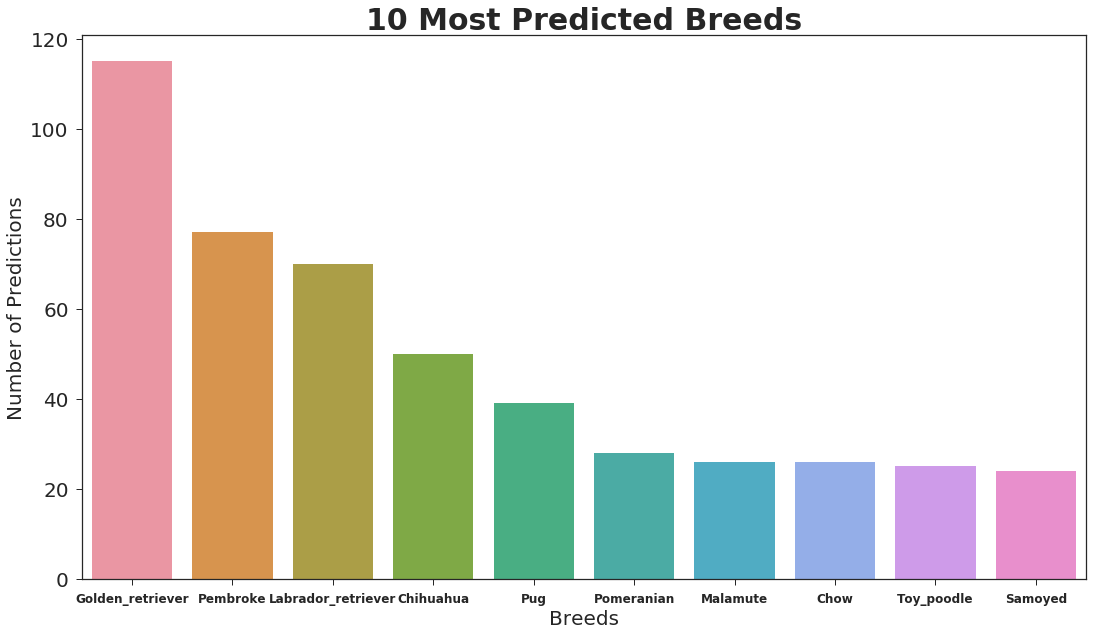

In [132]:
fig, ax = plt.subplots(figsize=(18,10))
labels = np.array(df_analysis.p1)
values = np.array(main_dog_breeds)
g = sns.barplot(x=main_dog_breeds.index, y=main_dog_breeds)
g.set_xticklabels(g.get_xticklabels())
ax = plt.gca()
plt.title('10 Most Predicted Breeds', fontsize = 30, loc = 'center', weight = 'bold')
plt.xlabel('Breeds', fontsize = 20)
plt.ylabel('Number of Predictions', fontsize = 20)
plt.xticks(fontsize=12, weight = 'bold')
plt.yticks(fontsize=20);




<a id='FAVORITES'></a>
## Tweets and Favorites

**What is the dog stage more tweeted?**

In [133]:
posts_per_stage = df_analysis.groupby('dog_stage').nunique()['tweet_id']
posts_sum_stage = posts_per_stage.sort_values(ascending=False).sum()
percentage_posts_stage = 100*posts_per_stage.sort_values(ascending=False)/posts_sum_stage
percentage_posts_stage = round(percentage_posts_stage.head(5))
percentage_posts_stage

dog_stage
           84.0
pupper     10.0
doggo       4.0
puppo       2.0
floofer     1.0
Name: tweet_id, dtype: float64

In [134]:
print('The stage with the greatest percentage of tweets was {}.'.format(round(percentage_posts_stage.head(2))))

The stage with the greatest percentage of tweets was dog_stage
          84.0
pupper    10.0
Name: tweet_id, dtype: float64.


**Which breed had the greatest number of tweets (percentage)?**

In [135]:
posts_per_breed = df_analysis.groupby('p1').nunique()['tweet_id']
posts_sum = posts_per_breed.sort_values(ascending=False).sum()
percentage_posts_breed = 100*posts_per_breed.sort_values(ascending=False)/posts_sum
percentage_posts_breed = round(percentage_posts_breed.head(5))
percentage_posts_breed

p1
Golden_retriever      10.0
Pembroke               7.0
Labrador_retriever     6.0
Chihuahua              4.0
Pug                    3.0
Name: tweet_id, dtype: float64

In [136]:
print('The breed which had the greatest number of tweets (percentage) was {}.'.format(round(percentage_posts_breed.head(1))))

The breed which had the greatest number of tweets (percentage) was p1
Golden_retriever    10.0
Name: tweet_id, dtype: float64.


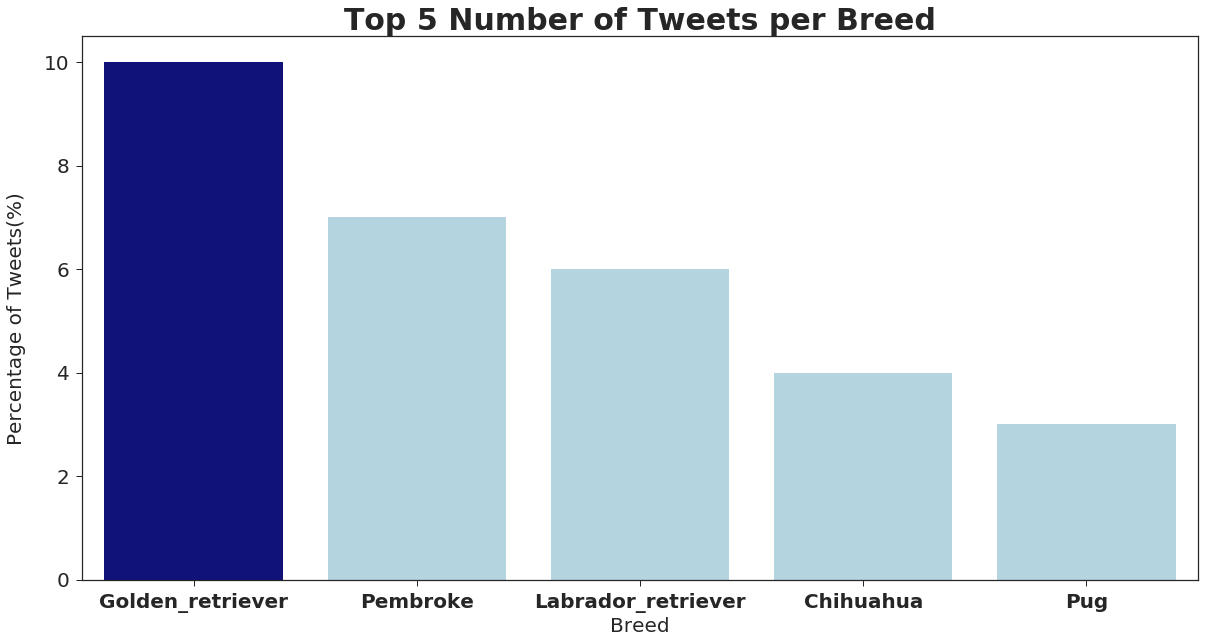

In [137]:
fig, ax = plt.subplots(figsize=(20,10))
labels = np.array(df_analysis.p1)
values = np.array(percentage_posts_breed) 
clrs = ['lightblue' if (x < max(values)) else 'darkblue' for x in values]
g = sns.barplot(x = percentage_posts_breed.index , y = percentage_posts_breed, palette = clrs, ax = ax)
plt.title('Top 5 Number of Tweets per Breed', fontsize = 30, loc = 'center', weight = 'bold')
plt.xlabel('Breed', fontsize = 20)
plt.ylabel('Percentage of Tweets(%)', fontsize = 20)
ax.yaxis.set_label_coords(-0.05,.48)
plt.xticks(fontsize=20, weight = 'bold')
plt.yticks(fontsize=20);

**What is the average of likes per tweet?**

In [138]:
avg_fav = round(df_analysis.favorites.mean())
print('On average, posts are favorited {} times.'.format(avg_fav))

On average, posts are favorited 8567.0 times.


**How many likes received the most favorited post?**

In [139]:
max_fav = round(df_analysis.favorites.max())
print('The most liked post received {} favorites.'.format(max_fav))

The most liked post received 132475 favorites.


In [140]:
print(df_analysis[df_analysis.favorites == df_analysis.favorites.max()]) 

              timestamp            tweet_id  name                p1 dog_stage  \
320 2017-01-21 18:26:02  822872901745569793  None  Lakeland_terrier     puppo   

     rating_numerator  retweets  favorites  \
320                13     43583     132475   

                                             jpg_url  
320  https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg  


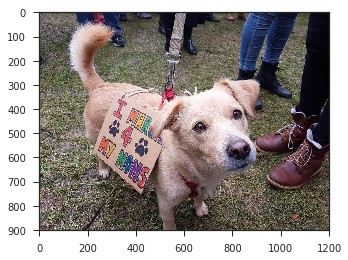

In [141]:
#check the picture of the Lakeland Terrier
from PIL import Image
import requests
import matplotlib.pyplot as plt
response = requests.get("https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg", stream=True)
img = Image.open(response.raw)

plt.imshow(img)
plt.show()

Is this your most favorite too?

**How many likes received the least favorited post?**

In [142]:
min_fav = round(df_analysis.favorites.min())
print('The least liked post received {} favorites.'.format(min_fav))

The least liked post received 70 favorites.


In [143]:
print(df_analysis[df_analysis.favorites == df_analysis.favorites.min()])

               timestamp            tweet_id  name              p1 dog_stage  \
2042 2015-11-16 03:55:04  666102155909144576  None  English_setter             

      rating_numerator  retweets  favorites  \
2042                11        11         70   

                                              jpg_url  
2042  https://pbs.twimg.com/media/CT54YGiWUAEZnoK.jpg  


In [144]:
#Lets take a look at the text to see if there is any indication for the reason for so little likes

In [145]:
lowest_fav = df_all.loc[df_all['tweet_id'] =='666102155909144576']
pd.set_option('display.max_colwidth', -1)
lowest_fav

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweets,favorites,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
2042,666102155909144576,2015-11-16 03:55:04,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Oh my. Here you are seeing an Adobe Setter giving birth to twins!!! The world is an amazing place. 11/10 https://t.co/11LvqN4WLq,https://twitter.com/dog_rates/status/666102155909144576/photo/1,11,10,None,11,70,...,English_setter,0.298617,True,Newfoundland,0.149842,True,Borzoi,0.133649,True,


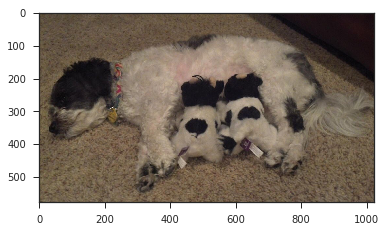

In [146]:
#check the picture of the English Setter
response = requests.get("https://pbs.twimg.com/media/CT54YGiWUAEZnoK.jpg", stream=True)
img = Image.open(response.raw)

plt.imshow(img)
plt.show()

Why did this picture recieved do little favorites? Perhaps, the fact that the 'puppies' are two stuffed cows?

**Which stage received the greatest number of favorites?**

In [147]:
favorite_per_stage = df_analysis.groupby('dog_stage').sum()['favorites']
favorite_stage_sum = favorite_per_stage.sort_values(ascending=False).sum()
percentage_favorite_stage = 100*favorite_per_stage.sort_values(ascending=False)/favorite_stage_sum
percentage_favorite_stage = round(percentage_favorite_stage)
percentage_favorite_stage

dog_stage
           78.0
pupper     9.0 
doggo      8.0 
puppo      4.0 
floofer    1.0 
Name: favorites, dtype: float64

In [148]:
print('The stage which received the greatest number of favorites (percentage) was {}.'.format(round(percentage_favorite_stage)))

The stage which received the greatest number of favorites (percentage) was dog_stage
           78.0
pupper     9.0 
doggo      8.0 
puppo      4.0 
floofer    1.0 
Name: favorites, dtype: float64.


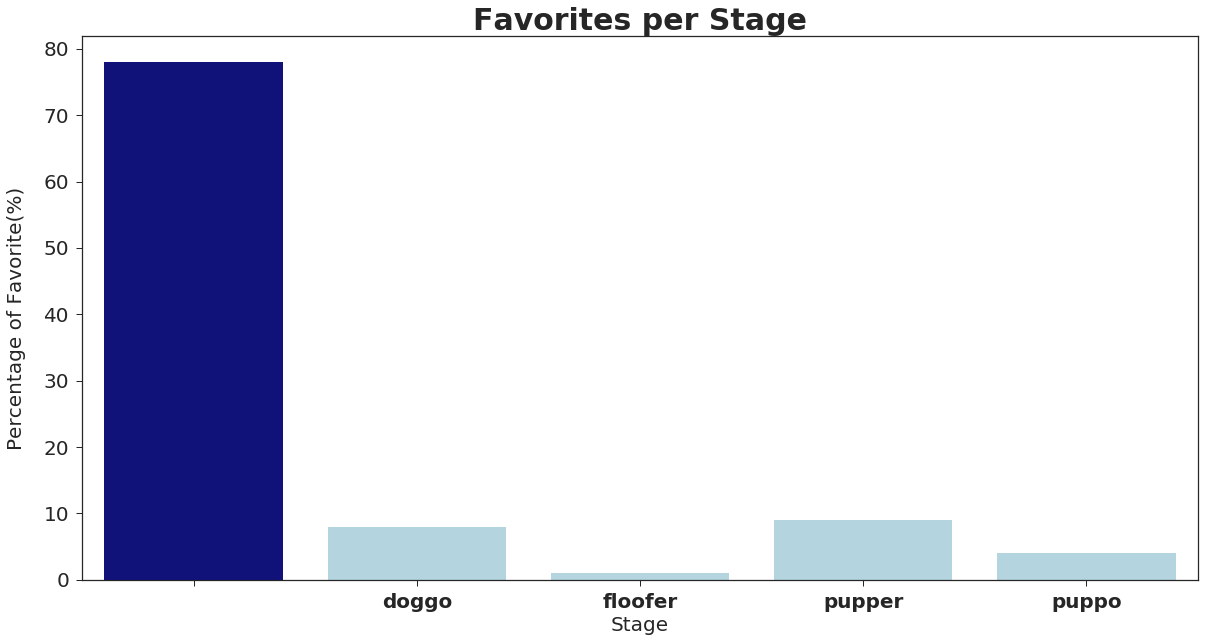

In [149]:
fig, ax = plt.subplots(figsize=(20,10))
labels = np.array(df_analysis.dog_stage)
values = np.array(percentage_favorite_stage) 
clrs = ['lightblue' if (x < max(values)) else 'darkblue' for x in values]
g = sns.barplot(x = percentage_favorite_stage.index , y = percentage_favorite_stage, palette = clrs, ax = ax)
plt.title('Favorites per Stage', fontsize = 30, loc = 'center', weight = 'bold')
plt.xlabel('Stage', fontsize = 20)
plt.ylabel('Percentage of Favorite(%)', fontsize = 20)
ax.yaxis.set_label_coords(-0.05,.48)
plt.xticks(fontsize=20, weight = 'bold')
plt.yticks(fontsize=20);

**Which breeds received the greatest number of favorites?**

In [150]:
favorite_per_breed = df_analysis.groupby('p1').sum()['favorites']
favorite_sum = favorite_per_breed.sort_values(ascending=False).sum()
percentage_favorite_breed = 100*favorite_per_breed.sort_values(ascending=False)/favorite_sum
percentage_favorite_breed = round(percentage_favorite_breed.head(5))
percentage_favorite_breed

p1
Golden_retriever      13.0
Pembroke              9.0 
Labrador_retriever    6.0 
Chihuahua             4.0 
French_bulldog        3.0 
Name: favorites, dtype: float64

In [151]:
print('The breed which received the greatest number of favorites (percentage) was {}.'.format(round(percentage_favorite_breed.head(1))))

The breed which received the greatest number of favorites (percentage) was p1
Golden_retriever    13.0
Name: favorites, dtype: float64.


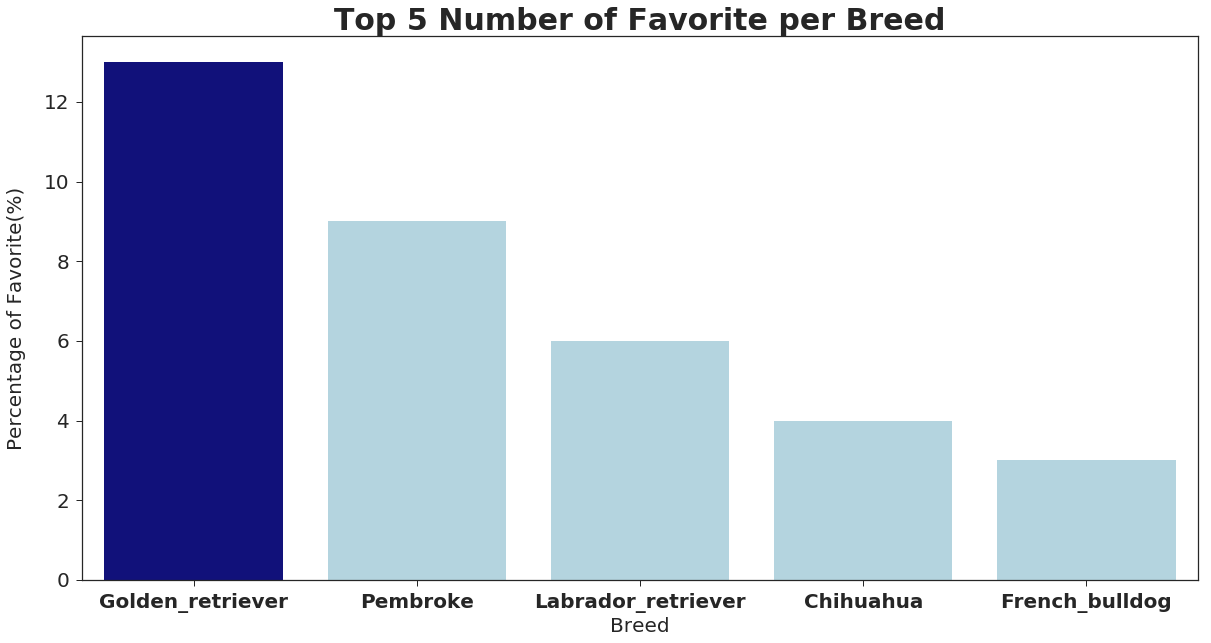

In [152]:
fig, ax = plt.subplots(figsize=(20,10))
labels = np.array(df_analysis.p1)
values = np.array(percentage_favorite_breed) 
clrs = ['lightblue' if (x < max(values)) else 'darkblue' for x in values]
g = sns.barplot(x = percentage_favorite_breed.index , y = percentage_favorite_breed, palette = clrs, ax = ax)
plt.title('Top 5 Number of Favorite per Breed', fontsize = 30, loc = 'center', weight = 'bold')
plt.xlabel('Breed', fontsize = 20)
plt.ylabel('Percentage of Favorite(%)', fontsize = 20)
ax.yaxis.set_label_coords(-0.05,.48)
plt.xticks(fontsize=20, weight = 'bold')
plt.yticks(fontsize=20);

<a id='RETWEETS'></a>
## Retweets

**What is the average of retweets per posts?**

In [153]:
avg_retweet = round(df_analysis.retweets.mean())
print('On average, posts are retweeted {} times.'.format(avg_retweet))

On average, posts are retweeted 2421.0 times.


**How many retweets received the most retweed post?**

In [154]:
max_retweet = round(df_analysis.retweets.max())
print('The most retweeted post was retweeted {} times.'.format(max_retweet))

The most retweeted post was retweeted 57435 times.


In [155]:
print(df_analysis[df_analysis.retweets == df_analysis.retweets.max()])

              timestamp            tweet_id  name          p1 dog_stage  \
873 2016-06-04 23:31:25  739238157791694849  None  Eskimo_dog  doggo      

     rating_numerator  retweets  favorites  \
873  13                57435     114880      

                                                                                     jpg_url  
873  https://pbs.twimg.com/ext_tw_video_thumb/739238016737267712/pu/img/-tLpyiuIzD5zR1et.jpg  


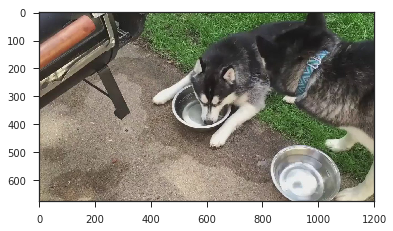

In [156]:
#check the picture of the Eskimo Dog
response = requests.get("https://pbs.twimg.com/ext_tw_video_thumb/739238016737267712/pu/img/-tLpyiuIzD5zR1et.jpg", stream=True)
img = Image.open(response.raw)

plt.imshow(img)
plt.show()

Why was this picture so retweed?

**How many retweets received the least retweed post?**

In [157]:
min_retweet = round(df_analysis.retweets.min())
print('The least retweeted post was retweeted {} times.'.format(min_retweet))

The least retweeted post was retweeted 11 times.


In [158]:
print(df_analysis[df_analysis.retweets == df_analysis.retweets.min()])

               timestamp            tweet_id  name              p1 dog_stage  \
2042 2015-11-16 03:55:04  666102155909144576  None  English_setter             

      rating_numerator  retweets  favorites  \
2042  11                11        70          

                                              jpg_url  
2042  https://pbs.twimg.com/media/CT54YGiWUAEZnoK.jpg  


**What was the most retweeted stage?**

In [159]:
retweets_per_stage = df_analysis.groupby('dog_stage').sum()['retweets']
retweets_stage_sum = retweets_per_stage .sort_values(ascending=False).sum()
percentage_retweets_stage = 100*retweets_per_stage .sort_values(ascending=False)/retweets_stage_sum
percentage_retweets_stage = round(percentage_retweets_stage.head())
percentage_retweets_stage

dog_stage
           77.0
pupper     9.0 
doggo      9.0 
puppo      4.0 
floofer    1.0 
Name: retweets, dtype: float64

In [160]:
print('The stage with the greatest percentage of retweets was {}.'.format(round(percentage_retweets_stage.head(1))))

The stage with the greatest percentage of retweets was dog_stage
    77.0
Name: retweets, dtype: float64.


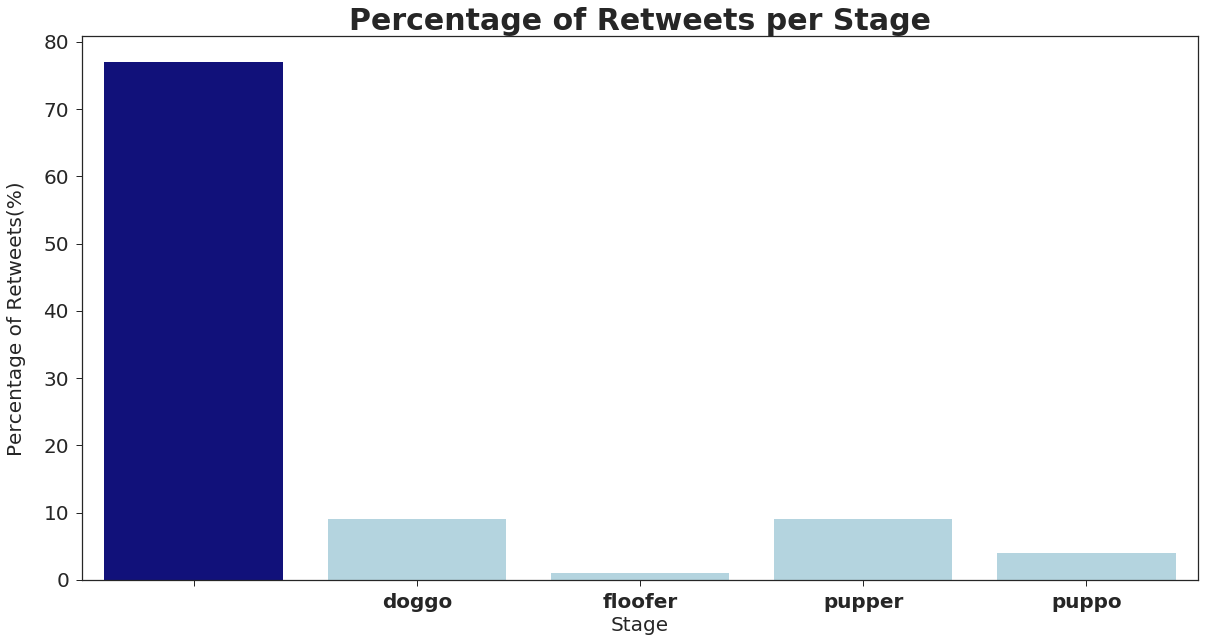

In [161]:
fig, ax = plt.subplots(figsize=(20,10))
labels = np.array(df_analysis.dog_stage)
values = np.array(percentage_retweets_stage) 
clrs = ['lightblue' if (x < max(values)) else 'darkblue' for x in values]
g = sns.barplot(x = percentage_retweets_stage.index , y = percentage_retweets_stage, palette = clrs, ax = ax)
plt.title('Percentage of Retweets per Stage', fontsize = 30, loc = 'center', weight = 'bold')
plt.xlabel('Stage', fontsize = 20)
plt.ylabel('Percentage of Retweets(%)', fontsize = 20)
ax.yaxis.set_label_coords(-0.05,.48)
plt.xticks(fontsize=20, weight = 'bold')
plt.yticks(fontsize=20);

**What was the most retweet breed (percentage)?**

In [162]:
retweets_per_breed = df_analysis.groupby('p1').sum()['retweets']
retweets_sum = favorite_per_breed.sort_values(ascending=False).sum()
percentage_retweets_breed = 100*retweets_per_breed.sort_values(ascending=False)/retweets_sum
percentage_retweets_breed = round(percentage_retweets_breed.head(5))
percentage_retweets_breed

p1
Golden_retriever      3.0
Pembroke              2.0
Labrador_retriever    2.0
Chihuahua             1.0
Samoyed               1.0
Name: retweets, dtype: float64

In [163]:
print('The breed which had the greatest percentage of retweets was {}.'.format(round(percentage_retweets_breed.head(1))))

The breed which had the greatest percentage of retweets was p1
Golden_retriever    3.0
Name: retweets, dtype: float64.


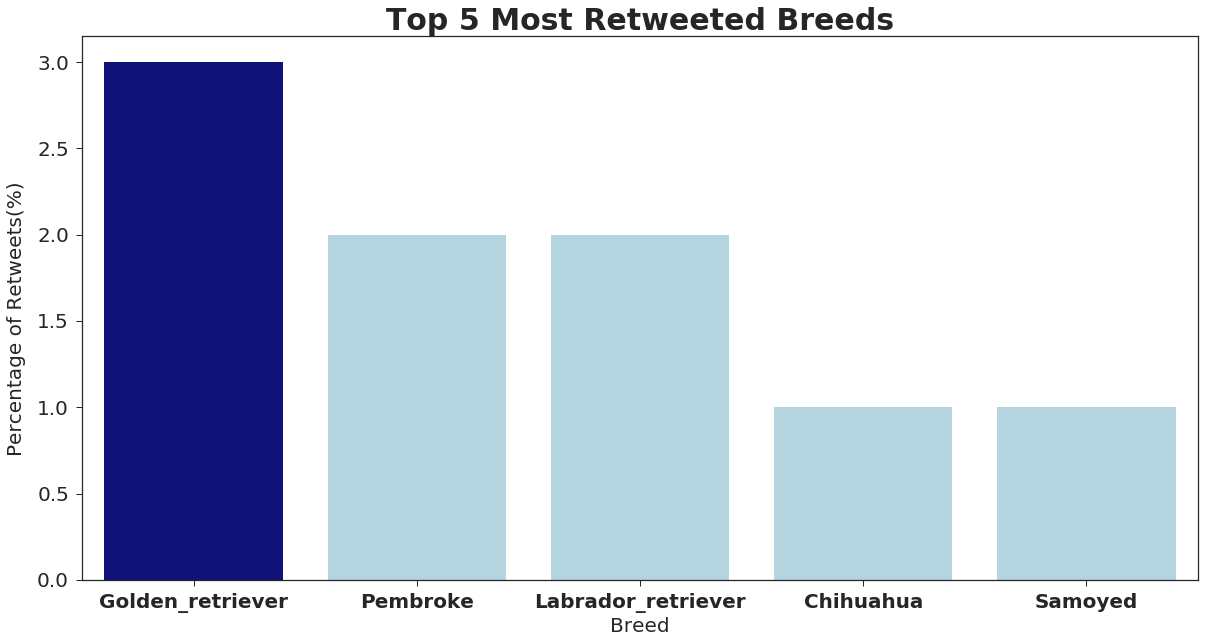

In [164]:
fig, ax = plt.subplots(figsize=(20,10))
labels = np.array(df_analysis.p1)
values = np.array(percentage_retweets_breed) 
clrs = ['lightblue' if (x < max(values)) else 'darkblue' for x in values]
g = sns.barplot(x = percentage_retweets_breed.index , y = percentage_retweets_breed, palette = clrs, ax = ax)
plt.title('Top 5 Most Retweeted Breeds', fontsize = 30, loc = 'center', weight = 'bold')
plt.xlabel('Breed', fontsize = 20)
plt.ylabel('Percentage of Retweets(%)', fontsize = 20)
ax.yaxis.set_label_coords(-0.05,.48)
plt.xticks(fontsize=20, weight = 'bold')
plt.yticks(fontsize=20);

<a id='RATINGS'></a>
## Ratings

**What is the average rank?**

In [165]:
ratings_rank = df_analysis['rating_numerator'].mean()
print('On average, dogs are rated at {}.'.format(round(ratings_rank)))

On average, dogs are rated at 11.0.


**What is the highest rating?**

In [166]:
top_rate = df_analysis['rating_numerator'].max()
print('The top rate a dog received a score of {}.'.format(round(top_rate)))

The top rate a dog received a score of 14.


In [167]:
#and here is a look of all dogs who scored 14

In [168]:
import pandas as pd
from IPython.display import Image, HTML

def path_to_image_html(path):

    return '<img src="'+ path + '" style=max-height:124px;"/>'

HTML(df_analysis[df_analysis.rating_numerator == df_analysis.rating_numerator.max()].to_html(escape=False ,formatters=dict(jpg_url=path_to_image_html)))

,timestamp,tweet_id,name,p1,dog_stage,rating_numerator,retweets,favorites,jpg_url
9,2017-07-26 15:59:51,890240255349198849,Cassie,Pembroke,doggo,14,6656,29743,
37,2017-07-10 15:58:53,884441805382717440,None,Pembroke,,14,5172,25299,
65,2017-06-23 01:10:23,878057613040115712,Emmy,French_bulldog,,14,6185,39348,
149,2017-04-24 15:13:52,856526610513747968,None,Old_english_sheepdog,,14,1794,11441,
150,2017-04-23 23:01:59,856282028240666624,Cermet,Chihuahua,,14,6019,26790,
156,2017-04-17 23:52:16,854120357044912130,None,Black-and-tan_coonhound,pupper,14,7188,31070,
265,2017-02-15 17:02:36,831911600680497154,Kuyu,Bloodhound,,14,6520,27644,
284,2017-02-06 17:02:17,828650029636317184,None,Golden_retriever,,14,1353,9531,
287,2017-02-05 23:15:47,828381636999917570,Doobert,Bedlington_terrier,doggo,14,2224,12622,
306,2017-01-29 02:44:34,825535076884762624,None,Rottweiler,puppo,14,17654,57140,


**What is the lowest rating?**

In [169]:
low_rate = df_analysis['rating_numerator'].min()
print('The lowest rate a dog received a score of {}.'.format(round(low_rate)))

The lowest rate a dog received a score of 2.


In [170]:
print(df_analysis[df_analysis.rating_numerator == df_analysis.rating_numerator.min()]) 

               timestamp            tweet_id     name           p1 dog_stage  \
1485 2015-12-20 03:58:55  678424312106393600  Crystal  Maltese_dog             

      rating_numerator  retweets  favorites  \
1485  2                 2494      5391        

                                              jpg_url  
1485  https://pbs.twimg.com/media/CWo_T8gW4AAgJNo.jpg  


In [171]:
#lets look at the text for the tweet to see if there is an indication that this score is incorrect

In [172]:
lowest_rating = df_all.loc[df_all['tweet_id'] =='678424312106393600']
pd.set_option('display.max_colwidth', -1)
lowest_rating

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweets,favorites,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
1485,678424312106393600,2015-12-20 03:58:55,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Crystal. She's a shitty fireman. No sense of urgency. People could be dying Crystal. 2/10 just irresponsible https://t.co/rtMtjSl9pz,https://twitter.com/dog_rates/status/678424312106393600/photo/1,2,10,Crystal,2494,5391,...,Maltese_dog,0.759945,True,Toy_poodle,0.101194,True,Shih-tzu,0.056037,True,


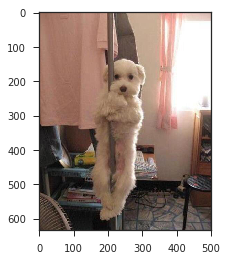

In [174]:
#check the picture of Crystal
from PIL import Image
import requests
import matplotlib.pyplot as plt
response = requests.get("https://pbs.twimg.com/media/CWo_T8gW4AAgJNo.jpg", stream=True)
img = Image.open(response.raw)

plt.imshow(img)
plt.show()

Does it look like this cutie deserve a 2 score to you?

**What is the average rating per stage?**

In [ ]:
rate_stage_avg = df_analysis.groupby('dog_stage')['rating_numerator'].mean().reset_index()
rate_stage_avg = rate_stage_avg

In [ ]:
print('The average rating per stage is {}.'.format(round(rate_stage_avg)))

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
labels = np.array(rate_stage_avg.dog_stage)
values = np.array(rate_stage_avg.rating_numerator) 
clrs = ['lightblue' if (x < max(values)) else 'darkblue' for x in values]
g = sns.barplot(x = 'dog_stage', y = 'rating_numerator', data = rate_stage_avg, palette = clrs, ax = ax)
plt.title("Average ratings per stage", fontsize = 30, loc = 'center', weight = 'bold')
plt.xlabel("Stage", fontsize = 25)
plt.ylabel("Average Rating (%)", fontsize = 25)
ax.yaxis.set_label_coords(-0.05,.48)
plt.xticks(fontsize=25)
plt.yticks(fontsize=20);

**What is the average rating per breed?**

In [ ]:
rate_breed_avg = df_analysis.groupby('p1')['rating_numerator'].mean()
rate_breed_avg = rate_breed_avg.sort_values(ascending=False)
rate_breed_avg = rate_breed_avg
rate_breed_avg.to_frame().head(5)

In [ ]:
top_breeds_ratings = rate_breed_avg.loc[['Golden_retriever', 'Pembroke', 'Labrador_retriever', 'Chihuahua', 'French_bulldog', 'Pug', 'Samoyed']].sort_values(ascending=False)
top_breeds_ratings

In [ ]:
print('The breed with the highest average rating is {}.'.format(round(top_breeds_ratings.head(1))))

<a id='conclusions'></a>
## Conclusions

In this section we will summarize the findings and results derived from the Exploratory Analysis.

**Overview**

I found that there is a positive correlation between the number of retweets and favorites. But, that over a time the number of favorites has grown more than the number of retweets.

**Tweets and Favorites**

A tweet receives favorites on average 8,568.

The maximum number of favorites was 1,32479. This tweet was from a dog of the breed Lakeland Terrier, at puppo stage, no declared name and received a score of 13.

The least number of favorites was 70. This tweet was from a dog of the breed English Setter, no declared name or stage, and received a score of 11. Here it is also hard to understand why the variable favorite was so low by looking at the picture.

Since p1 (algorithm) had the highest confidence level, I choose to analyze its predictions regarding the breed of the dogs on the tweeted pictures. Here are the most tweeted breeds: 

Golden Retriever 
Pembroke
Labrador Retriever
Chihuahua
Pug

The breeds that received more favorites were:
Golden Retriever
Pembroke
Labrador Retriever
Chihuahua
French Bulldog

With the data we have in hands, out of the non-Null values, the most tweeted and favorited dog is a pupper, a young dog. 

However, this information may be very inaccurate due to the large number of dogs who were not classified within a stage.


**Retweets**

Posts are on average are retweeted 2,421 times.

The breeds with more retweets were, not surprisingly:
Golden Retriever
Pembroke
Labrador Retriever
Chihuahua
Samoyed

The most retweeted posts was reposted 57,439. The most retweet post was of an Eskimo Dog, at doggo stage, no declared name and a score of 13.

The least retweeted post was reposted 11 times. The least retweet post the same as the least favorited was a dog of the breed English Setter, no declared name or staged, received a score of 11.

With the data we have in hands, out of the non-Null values, the most retweeted are dog pupper, a young dog and doggo, a dog older than a pupper. 

However, this information may be very inaccurate due to the large number of dogs who were not classified within a stage.

**Ratings** 

For the ratings I considered only the rating_numerator variable.
 
On average dogs are rated at 11 (numerator).

The highest rating was a score of 14. Among the list of the most tweeted, retweeted and favorited breeds, the dogs who scored 14 were:
Pembroke
French Bulldog
Chihuahua
Golden Retriever

The lowest rating was a score of 2. A dog named Crystal received that score. But by her picture and also looking at the pictures of the dogs that scored 14, it is hard to understand the parameter for the score.

None of the dogs in our top breeds list had this minimum score.

Among the list of the most tweeted, retweeted and favorited breeds, the average rating was:

Samoyed: 12
Golden Retriever: 12
Pembroke: 11
Labrador Retriever: 11
French Bulldog: 11
Chihuahua: 11
Pug: 10

As for stage, the average rating per stage was:
Doggo: 12
Floofer: 12
Puppo: 12
Pupper: 11
Null: 11

**Wrap up**

It appears that the most preferable or most common breeds in this dataset were
Golden Retriever, Pembroke, Labrador Retriever and Chihuahua.

This analysis was conducted to find preferences regarding breed and stage, to understand if and how they affect the number of tweets, favorites, retweets and ratings. Even though breed have a tendency towards four distinctive dogs, there seems to be very little evidence that breed, and stage have definitive, predictable influence. At least it was not possible to determine how with the analyzed data. Especially in regard to stage, since most of the tweets did not classify the dog’s stages.

We would need more information in order to reach firmer conclusions.